# Log Regression on Kickstarter Tech Campaigns
### Conducting EDA to extract top keywords and analyse their impact in predicting failure/success

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [4]:
# ✅ Load the dataset from full local path
file_path = "/Users/shiying/Desktop/fintech soc/Crowdfunding Proj y2s2/datasets/Kickstarter_2025-02-12T07_48_27_293Z/Kickstarter_TechFiltered_TechOnly.csv"
df = pd.read_csv(file_path)

              precision    recall  f1-score   support

           0       0.68      0.17      0.28      1599
           1       0.58      0.94      0.72      1973

    accuracy                           0.59      3572
   macro avg       0.63      0.55      0.50      3572
weighted avg       0.63      0.59      0.52      3572



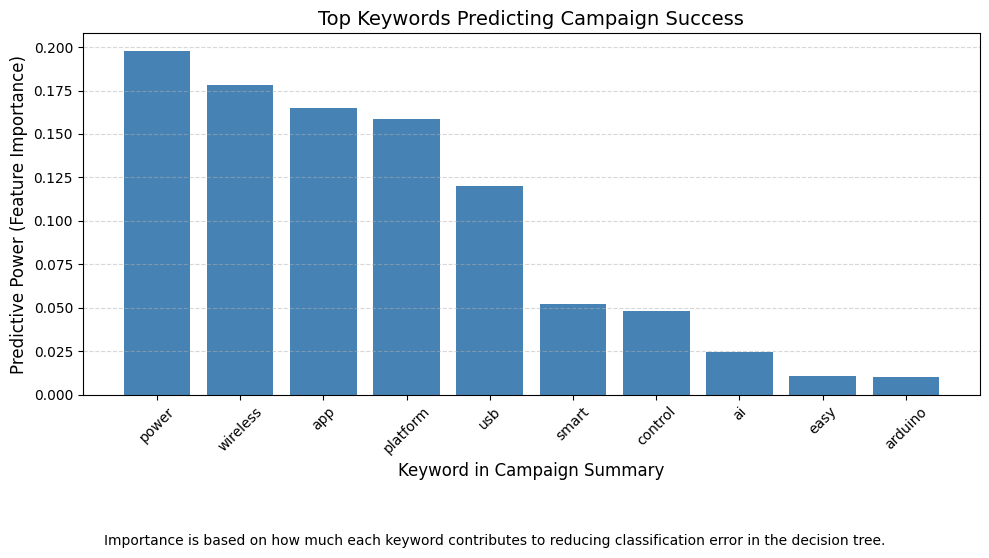


Top keywords influencing success:
- power: 0.198
- wireless: 0.178
- app: 0.165
- platform: 0.159
- usb: 0.120
- smart: 0.052
- control: 0.048
- ai: 0.025
- easy: 0.011
- arduino: 0.010


In [5]:
# Drop rows without campaign summaries or state
df = df.dropna(subset=['campaign_summary', 'state'])

# Create binary target variable: 1 = successful, 0 = not
df['success'] = df['state'].apply(lambda x: 1 if str(x).lower() == 'successful' else 0)

# Extract keyword features from campaign summaries
vectorizer = CountVectorizer(stop_words='english', max_features=30)
X_text = vectorizer.fit_transform(df['campaign_summary'])

# Define target
y = df['success']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Train decision tree classifier
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Get feature importance
feature_names = vectorizer.get_feature_names_out()
importances = clf.feature_importances_
important_keywords = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Plot: Top keywords predicting campaign success
top_keywords = important_keywords[:10]
plt.figure(figsize=(10, 5))
plt.bar([kw[0] for kw in top_keywords], [kw[1] for kw in top_keywords], color='steelblue')

plt.title("Top Keywords Predicting Campaign Success", fontsize=14)
plt.ylabel("Predictive Power (Feature Importance)", fontsize=12)
plt.xlabel("Keyword in Campaign Summary", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Explanatory note
plt.figtext(
    0.5, -0.1,
    "Importance is based on how much each keyword contributes to reducing classification error in the decision tree.",
    wrap=True, horizontalalignment='center', fontsize=10
)

plt.show()

# Print top keywords to console as well
print("\nTop keywords influencing success:")
for word, importance in top_keywords:
    print(f"- {word}: {importance:.3f}")


#### Analysis of Results
Strengths: 
- High recall (0.94) for predicting successful campaigns → the model is really good at identifying what WILL succeed.
- F1-score of 0.72 for successful class is quite strong for a simple model based on text.

Weaknesses:
- Very low recall (0.17) for predicting failed campaigns → it rarely correctly identifies what will fail. This results in a lot of false positives (labeling failed projects as successful).
- Overall accuracy is moderate (59%) but heavily biased toward the dominant class.

Possible reason: class imbalance (more successes than failures).

The model overfitting to keywords that signal success, not distinguishing what causes failure.


### Improvements
1. Improving model balance: 
    - try upsampling the "failed" class or using class weights in the decision tree to help it learn what failure looks like
    - test a **logistic regression** with ONLY text features
2. Feature Engineering: 
    - use Term Frequency - Inverse Document Frequency (TF-IDF) instead of raw counts for better weighting 
    - rationale: reduces the impact of common words (e.g., "project", "product", "launch") that appear in many campaign, boosts rare but meaningful terms (eg, "wireless", "arduino", "app") that might define specific niches and helps the model focus on distinctive keywords that actually help differentiate successful vs. failed campaigns.
3. Keyword Tagging: 
    - use these top keywords to tag or cluster campaigns based on their themes (eg. “wireless” + “usb” = peripherals)

              precision    recall  f1-score   support

           0       0.66      0.82      0.74      1599
           1       0.82      0.66      0.73      1973

    accuracy                           0.73      3572
   macro avg       0.74      0.74      0.73      3572
weighted avg       0.75      0.73      0.73      3572



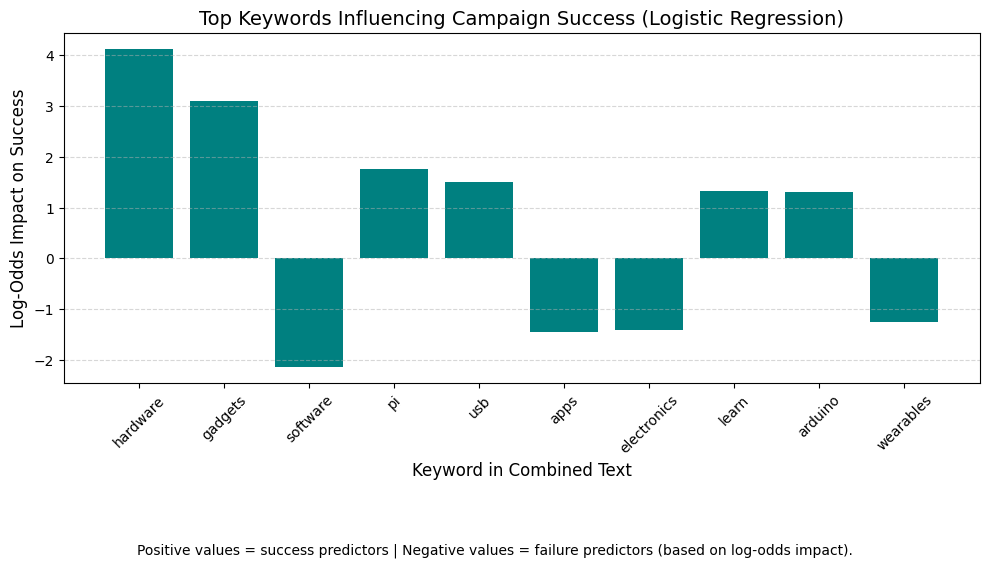


Top keywords influencing campaign success:
- hardware: 4.129 (↑ success)
- gadgets: 3.100 (↑ success)
- software: -2.144 (↓ failure)
- pi: 1.754 (↑ success)
- usb: 1.502 (↑ success)
- apps: -1.460 (↓ failure)
- electronics: -1.416 (↓ failure)
- learn: 1.332 (↑ success)
- arduino: 1.299 (↑ success)
- wearables: -1.257 (↓ failure)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ✅ Drop rows with missing target or summary
df = df.dropna(subset=['campaign_summary', 'state'])

# ✅ Create binary target variable
df['success'] = df['state'].apply(lambda x: 1 if str(x).lower() == 'successful' else 0)

# ✅ Ensure 'campaign_name' column exists and has no NaNs
if 'campaign_name' not in df.columns:
    df['campaign_name'] = ''
else:
    df['campaign_name'] = df['campaign_name'].fillna('')

# ✅ Combine category name, campaign name, and summary for richer text context
df['combined_text'] = (
    df['category_name'].fillna('') + ' ' +
    df['campaign_name'] + ' ' +
    df['campaign_summary'].fillna('')
).str.lower()

# ✅ Use TF-IDF to vectorize combined text (improves weighting of rarer keywords)
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_text = vectorizer.fit_transform(df['combined_text'])

# ✅ Target variable
y = df['success']

# ✅ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# ✅ Logistic Regression with class weights to balance skewed success/failure ratio
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# ✅ Evaluate model performance
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# ✅ Extract and rank important keywords by absolute log-odds
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]
important_keywords = sorted(zip(feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)

# ✅ Select top 10 most impactful keywords
top_keywords = important_keywords[:10]

# ✅ Plot keyword importance with meaningful axis labels
plt.figure(figsize=(10, 5))
plt.bar([kw[0] for kw in top_keywords], [kw[1] for kw in top_keywords], color='teal')
plt.title("Top Keywords Influencing Campaign Success (Logistic Regression)", fontsize=14)
plt.ylabel("Log-Odds Impact on Success", fontsize=12)
plt.xlabel("Keyword in Combined Text", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.figtext(
    0.5, -0.12,
    "Positive values = success predictors | Negative values = failure predictors (based on log-odds impact).",
    wrap=True, horizontalalignment='center', fontsize=10
)
plt.show()

# ✅ Print top keywords with log-odds impact
print("\nTop keywords influencing campaign success:")
for word, impact in top_keywords:
    direction = "↑ success" if impact > 0 else "↓ failure"
    print(f"- {word}: {impact:.3f} ({direction})")


#### Analysis of Results
Using a logistic regression model trained on TF-IDF-transformed campaign descriptions, we identified key terms that strongly influence whether a technology-focused Kickstarter campaign succeeds or fails. The model achieved a balanced performance, with 73% accuracy and comparable precision/recall across both success and failure classes.

**SUCCESS-PREDICTING KEYWORDS:**
- Words like "hardware", "gadgets", "pi", "usb", "arduino", and "learn" show strong positive log-odds, meaning their presence significantly increases the likelihood of campaign success.
- These words are often associated with:
    - Tangible, buildable products
    - DIY/maker culture (eg. Arduino, Raspberry Pi)
    - Educational or functional use cases
    - Clear utility and real-world application

**FAILURE-PREDICTING KEYWORDS:**
- Words like "software", "apps", "electronics", and "wearables" have negative coefficients, indicating they are more commonly found in unsuccessful campaigns.
- These may suggest:
    - Overcrowded or saturated markets (apps/software)
    - Vague or less tangible ideas
    - Concepts that are harder to convey value clearly (eg. abstract software or generalized “electronics”)

### Combining both text & numeric features in the model

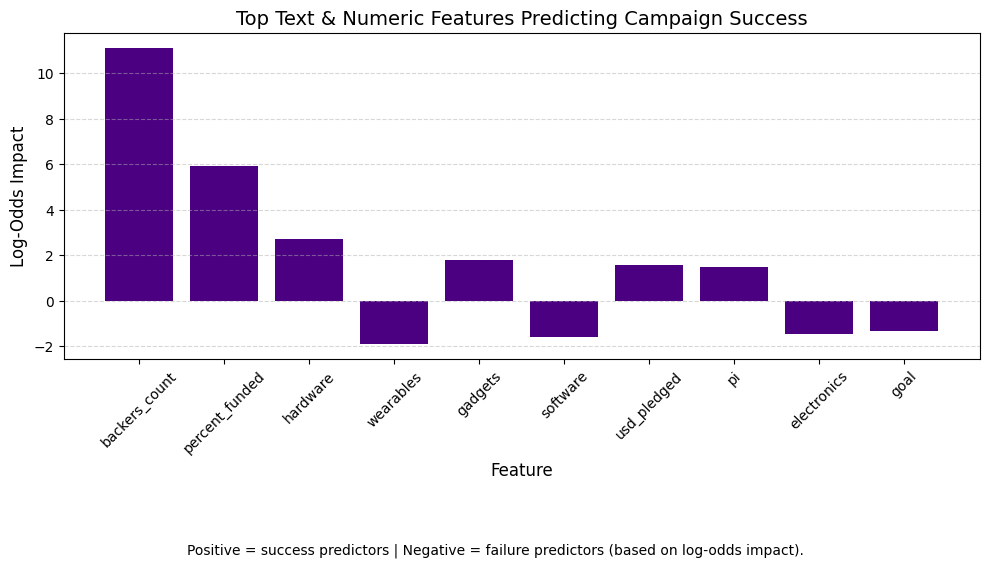

Top Keywords & Numeric Features Influencing Campaign Success:
- backers_count: 11.113 (↑ success)
- percent_funded: 5.923 (↑ success)
- hardware: 2.702 (↑ success)
- wearables: -1.913 (↓ failure)
- gadgets: 1.804 (↑ success)
- software: -1.611 (↓ failure)
- usd_pledged: 1.585 (↑ success)
- pi: 1.485 (↑ success)
- electronics: -1.459 (↓ failure)
- goal: -1.349 (↓ failure)

📊 Cleaned Model Evaluation Report:

              precision  recall  f1-score  support
0                 0.783   0.909     0.842   1599.0
1                 0.916   0.796     0.852   1973.0
macro avg         0.849   0.853     0.847   3572.0
weighted avg      0.856   0.847     0.847   3572.0


In [12]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# Re-load dataset
file_path = "/Users/shiying/Desktop/fintech soc/Crowdfunding Proj y2s2/datasets/Kickstarter_2025-02-12T07_48_27_293Z/Kickstarter_TechFiltered_TechOnly.csv"
df = pd.read_csv(file_path)
df = df.dropna(subset=['campaign_summary', 'state'])
df['success'] = df['state'].apply(lambda x: 1 if str(x).lower() == 'successful' else 0)

# Ensure 'campaign_name' exists
if 'campaign_name' not in df.columns:
    df['campaign_name'] = ''
else:
    df['campaign_name'] = df['campaign_name'].fillna('')

# Combine text columns
df['combined_text'] = (
    df['category_name'].fillna('') + ' ' +
    df['campaign_name'] + ' ' +
    df['campaign_summary'].fillna('')
).str.lower()

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_text = vectorizer.fit_transform(df['combined_text'])

# Select numeric features
numeric_features = [
    'goal', 'fx_rate', 'percent_funded',
    'usd_pledged', 'converted_pledged_amount',
    'backers_count', 'staff_pick'
]
X_numeric = df[numeric_features].fillna(0)
X_numeric_scaled = StandardScaler().fit_transform(X_numeric)

# Combine TF-IDF + numeric
X_combined = hstack([X_text, X_numeric_scaled])
y = df['success']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train logistic regression on combined features
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Predict & evaluate
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Extract importance: combine text and numeric feature names
feature_names_text = vectorizer.get_feature_names_out().tolist()
feature_names_combined = feature_names_text + numeric_features
coefs = clf.coef_[0]
important_features = sorted(zip(feature_names_combined, coefs), key=lambda x: abs(x[1]), reverse=True)

# Plot top 10 combined features
top_features = important_features[:10]
plt.figure(figsize=(10, 5))
plt.bar([kw[0] for kw in top_features], [kw[1] for kw in top_features], color='indigo')
plt.title("Top Text & Numeric Features Predicting Campaign Success", fontsize=14)
plt.ylabel("Log-Odds Impact", fontsize=12)
plt.xlabel("Feature", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.figtext(
    0.5, -0.12,
    "Positive = success predictors | Negative = failure predictors (based on log-odds impact).",
    wrap=True, horizontalalignment='center', fontsize=10
)
plt.show()

important_features[:10], report

# ✅ Cleaned output: round feature importances to 3 decimal places
rounded_features = [(name, round(float(score), 3)) for name, score in important_features[:10]]

# ✅ Cleaned classification report (rounded to 3 decimals)
cleaned_report = {
    label: {
        metric: round(score, 3)
        for metric, score in metrics.items()
    } for label, metrics in report.items()
    if isinstance(metrics, dict)
}

# ✅ Print the cleaned output
print("Top Keywords & Numeric Features Influencing Campaign Success:")
for name, value in rounded_features:
    direction = "↑ success" if value > 0 else "↓ failure"
    print(f"- {name}: {value} ({direction})")

# ✅ Convert cleaned_report to a DataFrame for tabular display
report_df = pd.DataFrame(cleaned_report).T  # Transpose so classes are rows

# ✅ Reorder columns for clarity (optional)
ordered_cols = ['precision', 'recall', 'f1-score', 'support']
report_df = report_df[ordered_cols]

# ✅ Round and format the table
report_df = report_df.round(3)

# ✅ Print the table
print("\n📊 Cleaned Model Evaluation Report:\n")
print(report_df)



#### Analysis of Results
With the integration of both textual features (from campaign summaries) and numeric indicators (like funding and engagement metrics), the logistic regression model delivers strong predictive performance and interpretability.

Based on its performance metrics, the model is highly balanced, effectively predicting both successful and failed campaigns — a major improvement over earlier text-only models (~73% accuracy).

**Features' Predictive Power:**
- Numeric features dominate
    - backers_count and percent_funded are by far the strongest signals of success — this makes sense since they directly reflect momentum and trust.
    - goal being negative shows that ambitious funding targets may reduce chances unless paired with strong messaging.
- Textual features still matter:
    - Keywords like "hardware" and "gadgets" are consistently positive signals.
    - Conversely, broad or ambiguous terms like "software", "wearables", and "electronics" reduce success odds — possibly due to market saturation or lack of clarity.